In [1]:
import re
import sys
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns

sys.path.append('../lib')
from stats_utils import corr_perm_test, p2str
from local_paths import database_dir, mplstyle_path, annot_path
from summary_utils import annotate_unit_df, select_units, region_palette

In [2]:
plt.style.use(mplstyle_path)

# Parameters

In [3]:
results_dir = '../Postprocessing/Latency/summary/'
st_lat_path = results_dir + 'stim_on_latency.csv.gz'
fx_lat_path = results_dir + 'fix_on_latency.csv.gz'

# analysis-specific conditions
boots_spread = 25  # for plotting only

# unit selection
unit_sel_path = database_dir + 'unit_sel/fixation_selective.csv.gz'

In [4]:
unit_sel_path = Path(unit_sel_path)

# Load data

In [5]:
dfs = []
shared_idc = None
for p in (st_lat_path, fx_lat_path):
    df = pd.read_csv(p)
    df = df[df['Level']=='Unit'].rename(columns={'Name':'Unit'}).set_index(['Session','Unit'])
    dfs.append(df)
    if shared_idc is None:
        shared_idc = df.index
    else:
        shared_idc = df.index.intersection(shared_idc)

print(f'{len(shared_idc)} shared units')
dfs = [df.loc[shared_idc] for df in dfs]

791 shared units


# Select units

In [6]:
dfs[0] = annotate_unit_df(dfs[0].reset_index()).reset_index()
unit_sel, regions = select_units(
    dfs[0],
    selection_path=unit_sel_path,
    exclude_rare_subjects_per_region=False)[1:]
dfs = [df.iloc[unit_sel] for df in dfs]

> Selected units: n = 787 of 791 (99.5% of data, 4.8% of selection) based on fixation_selective.csv.gz


# Make plots

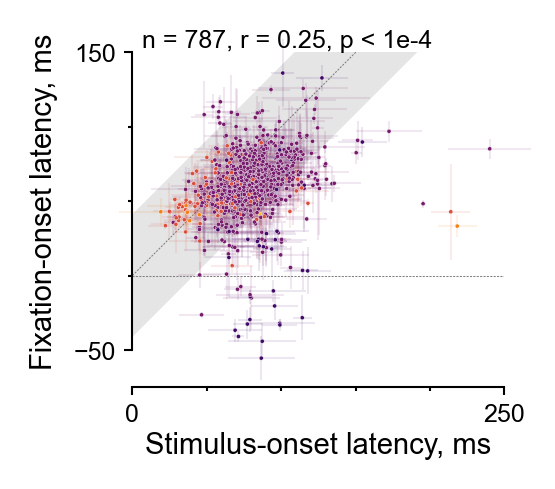

In [7]:
fig = plt.figure(figsize=(1.6,1.6), dpi=300)
ax = plt.gca()

x = dfs[0]['Latency'].values
y = dfs[1]['Latency'].values
colors = np.array([region_palette[v] for v in dfs[0]['Region'].values])
plt.scatter(x, y, s=1, fc=colors, ec='w', linewidths=0.1, zorder=2, clip_on=False)

xe = dfs[0]['Boots. stdev.'].values
ye = dfs[1]['Boots. stdev.'].values
plt.errorbar(x, y, xe, ye, fmt='none', ecolor=colors, elinewidth=0.5, alpha=0.1, zorder=1, clip_on=False)

r = st.pearsonr(x, y)[0]
p = corr_perm_test(x, y)
ax.text(
    .025, 1, f'n = {len(x)}, r = {r:.2f}, p {p2str(p, return_cmp=True)}',
    ha='left', va='bottom', transform=ax.transAxes, fontsize=6)

l = 0
u = 250
kw = dict(lw=0.25, ls='--', zorder=-1, color='gray')
ax.plot([l,u], [l,u], **kw)
ax.hlines(0, l, u, **kw)
s = 1.65 * boots_spread  # 90% CI of Gaussian
ax.fill_between([l,u], [l-s,u-s], [l+s,u+s], fc='gray', ec='none', alpha=0.2, zorder=-2)

res = 200
mres = 50
xlim = (0, 250)
xbound = xlim
xtks = xbound
xmtks = np.arange(xbound[0], xbound[1]+1, mres)
ax.set_xlim(xlim)
ax.set_xticks(xtks)
ax.set_xticks(xmtks, minor=True)
ax.spines['bottom'].set_bounds(xbound)

ylim = (-75, 150)
ybound = (-50, 150)
ytks = ybound
ymtks = np.arange(ybound[0], ybound[1]+1, mres)
ax.set_ylim(ylim)
ax.set_yticks(ytks)
ax.set_yticks(ymtks, minor=True)
ax.spines['left'].set_bounds(ybound)

ax.set_aspect('equal')

ax.set_xlabel('Stimulus-onset latency, ms')
ax.set_ylabel('Fixation-onset latency, ms')
tform = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)
ax.yaxis.set_label_coords(-.2, np.mean(ybound), transform=tform)

plt.savefig('plots/fig5c.png')

In [8]:
m = y < 0
print(f'{m.sum()} of {m.size} units ({m.mean()*100:.1f}%) have fix-on latency < 0')

17 of 787 units (2.2%) have fix-on latency < 0


In [9]:
d = y - x
print('Fix-on latency less than stim-on latency?')
print(st.wilcoxon(x, y, alternative='greater'))
print('median +/- MAD: %.0f +/- %.0f ms' % (np.median(d), np.median(np.abs(d - np.median(d)))))
print('SEM: %.2f' % st.sem(d))
pd.Series(d).describe()

Fix-on latency less than stim-on latency?
WilcoxonResult(statistic=266482.0, pvalue=1.2342446632130229e-68)
median +/- MAD: -16 +/- 14 ms
SEM: 1.02


count    787.000000
mean     -18.778297
std       28.514742
min     -185.017822
25%      -30.049697
50%      -16.356180
75%       -1.545675
max       59.927130
dtype: float64

In [10]:
t = 1.65*boots_spread
dfs[0]['Index'] = np.arange(len(dfs[0]))

for m, s in (
        (d < -t, '<'),
        (d > t, '>')):
    print(f'{m.sum()} of {m.size} units ({m.mean()*100:.1f}%) have fix-on {s} stim-on latency more than {t:.1f} ms')
    m0 = m.copy()
    for region, df_ in dfs[0].groupby('Region'):
        m = m0[df_['Index']]
        print(region, f'\t{m.sum()} of {m.size} units ({m.mean()*100:.1f}%) have fix-on {s} stim-on latency more than {t:.1f} ms')
    print()

112 of 787 units (14.2%) have fix-on < stim-on latency more than 41.2 ms
AIT 	26 of 40 units (65.0%) have fix-on < stim-on latency more than 41.2 ms
CIT 	75 of 626 units (12.0%) have fix-on < stim-on latency more than 41.2 ms
V1 	1 of 2 units (50.0%) have fix-on < stim-on latency more than 41.2 ms
V2 	1 of 6 units (16.7%) have fix-on < stim-on latency more than 41.2 ms
V4 	9 of 113 units (8.0%) have fix-on < stim-on latency more than 41.2 ms

7 of 787 units (0.9%) have fix-on > stim-on latency more than 41.2 ms
AIT 	0 of 40 units (0.0%) have fix-on > stim-on latency more than 41.2 ms
CIT 	7 of 626 units (1.1%) have fix-on > stim-on latency more than 41.2 ms
V1 	0 of 2 units (0.0%) have fix-on > stim-on latency more than 41.2 ms
V2 	0 of 6 units (0.0%) have fix-on > stim-on latency more than 41.2 ms
V4 	0 of 113 units (0.0%) have fix-on > stim-on latency more than 41.2 ms

